In [1]:
from astropy import units as u
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import pickle

from fil_finder import FilFinder2D

from cube_fil_finder.galfa import galfa_util
from cube_fil_finder.util import cube_util, cube_moments

%matplotlib inline

### modify these for you own data locations


`pickle_file_all_trees`: this file should contain the actual pickled tree structures

`galfa_file_sample`: this could be any GALFA slice, it's used later for its header info

In [2]:
pickle_file_all_trees = '../../pickled_dicts/fourth_batch/all_trees_1_8.p'
galfa_file_sample = '/Volumes/LarryExternal1/Research_2017/GALFA_slices_backup/unprocessed_slices_from_susan/GALFA_HI_W_S0955_V-050.4kms.fits'

In [3]:
trees = pickle.load(open(pickle_file_all_trees, 'rb'))  # dict of tree objects
ex_hdr = fits.getheader(galfa_file_sample)

In [4]:
ex_hdr['BUNIT'] = 'k'  # this is a workaround for filfinder

choose your own `tree_key` here: it should be a key in `trees`, which should correspond to the __id__ column of the datafile

In [5]:
tree_key = '994_1050_0'  # example key
tree = trees[tree_key]

### getting the data from the tree object

here we'll go from the tree object, which contains the mask for each velocity channel, along with information on the channel # & mask corners, to a 3d numpy array in (v, y, x) index.

There are 3 ways to do this - choose whatever is easiest for you:

__1:__

`galfa_util.get_galfa_data_cube_from_tree()` is something I wrote a while ago for this. Before you run this what you want to do is go in to `cube_fil_finder.galfa.galfa_util.py` and modify line 17 & 18. They contain the default location for the raw and the unsharp-masked GALFA slices. (if you've already imported the `galfa_util` you'll have to reimport it - sorry!)

In [7]:
data_cube_raw = galfa_util.get_galfa_data_cube_from_tree(tree, cube_type='raw')
data_cube_umask = galfa_util.get_galfa_data_cube_from_tree(tree, cube_type='umask30')

__2:__

if you don't want to touch `cube_fil_finder.galfa.galfa_util.py` (which I totally get), this is how `galfa_util.get_galfa_data_cube_from_tree()` is implemented:

`galfa_util.get_galfa_slice_paths_from_tree()` uses glob to get a list of matching location for data slices based on the velocity channel location stored in the tree (this does assume that your data slices follow the naming convention & look something this: `GALFA_HI_W_S0955_V-050.4kms.fits`)

the list of file names is then passed into `galfa_util.get_cut_cube_from_galfa_slice_paths()` which will go through each of the data slices, load them into memory, and cut out the part that we need from the corner information stored in the tree. It then combines that list of data slices into a numpy array

In [ ]:
raw_data_dir = ''
data_slice_paths_raw = galfa_util.get_galfa_slice_paths_from_tree(tree, raw_data_dir)
data_cube_raw = galfa_util.get_cut_cube_from_galfa_slice_paths(data_slice_paths_raw, tree)

umask_data_dir = ''
data_slice_paths_umask = galfa_util.get_galfa_slice_paths_from_tree(tree, umask_data_dir)
data_cube_umask = galfa_util.get_cut_cube_from_galfa_slice_paths(data_slice_paths_umask, tree)

__3:__

if you already have something you wrote yourself, feel free to use it here lol

In [22]:
# your code goes here:
# ...
#

### getting the moment 0 map & integrated intensity map from the data cube

I use `cube_moments.moment_0_from_cube()` to collapse the data cube. A caveat here is that the raw moment 0 map has to undergo unsharp masking (done by `cube_util.umask()` that I stole from Susan I think), while the moment 0 map from the unsharp-masked slices don't have to be unsharp maske again.

In [8]:
moment_0_map_raw_pre_umask = np.nan_to_num(cube_moments.moment_0_from_cube(data_cube_raw))
moment_0_map_raw = cube_util.umask(moment_0_map_raw_pre_umask, radius=30, filter_opt='gaussian')
# get a list of cut (to tree corners & tree velocities), umask galfa slices

moment_0_map_umask = np.nan_to_num(cube_moments.moment_0_from_cube(data_cube_umask))

(132, 182)


a caveat on masking: a while ago Avery and I talked about the correct way to mask these. Currently in the above functions neither the individual data slices nor the collapsed moment 0 map is masked. In the function `cube_moments.moment_0_from_cube()`, there is the option to provide a mask, but when we don't, we get a simple collapse of the individual velocity slics.

the reason I decided not to mask this step is because this moment 0 map is later passed into fil_finder and we give it the `tree_mask` there for it to mask the moment 0. Feel free to dissagree & pass in a mask - just make sure it's the same shape.

on the masking algorithm itself, currently what the code does is that it 
1. defines the `tree_mask` to be the collective binary AND of all the individual (aligned) channel masks
1. masks all the individual GALFA slices with that `tree_mask`
1. collapses the 3d numpy array into the 2d moment 0 map

where the better way that Avery talked about was to 
1. masks the individual slices with their corresponding channel mask
1. collapses the 3d numpy array into the 2d moment 0 map & convert NaNs to zeros

I have not implemented the better way, but maybe Avery has something(?)

### fil_finder comes back in...

here `tree.root_node.mask` is the collective binary AND of all the individual (aligned) channel masks. By passing this in fil_finder skips its own thresholding & masking. This mask is applied to the 2d image as a whole.

if you don't pass it in fil_finder will create its own mask, in that case don't forget to set `use_existing_mask` to `False`

In [9]:
fils_raw = FilFinder2D(moment_0_map_raw, header=ex_hdr, distance=100. * u.pc, beamwidth=4. * u.arcmin,
                       mask=tree.root_node.mask)
fils_umask = FilFinder2D(moment_0_map_umask, header=ex_hdr, distance=100. * u.pc, beamwidth=4. * u.arcmin,
                       mask=tree.root_node.mask)

fils_raw.preprocess_image(flatten_percent=95)
fils_umask.preprocess_image(flatten_percent=95)

fils_raw.create_mask(use_existing_mask=True, verbose=True)
fils_umask.create_mask(use_existing_mask=True, verbose=True)

/Users/larryli/anaconda/envs/py27research/lib/python2.7/site-packages/fil_finder/filfinder2D.py:289: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


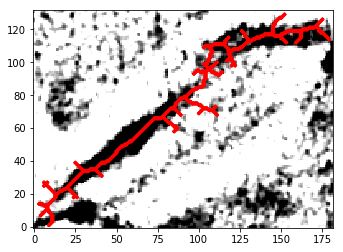

In [10]:
fils_raw.medskel(verbose=True)

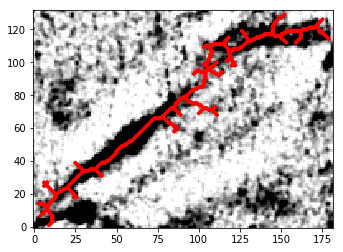

In [11]:
fils_umask.medskel(verbose=True)

In [12]:
fils_raw.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)
fils_umask.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)

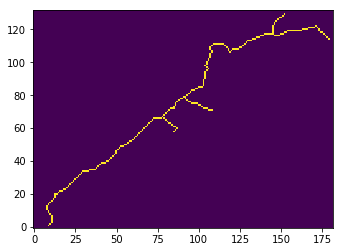

In [13]:
plt.imshow(fils_raw.skeleton, origin='lower')

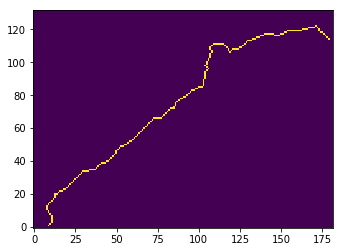

In [14]:
plt.imshow(fils_raw.skeleton_longpath, origin='lower')

In [15]:
fils_raw.exec_rht()
fils_umask.exec_rht()

Filament: 1 / 1


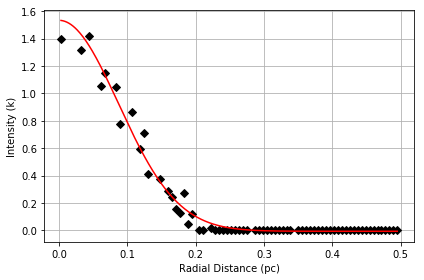

In [16]:
fils_raw.find_widths(try_nonparam=False, auto_cut=False,
                     max_dist=0.5 * u.pc, verbose=True,
                     use_longest_path=False, add_width_to_length=False,
                     deconvolve_width=False, xunit=u.pc)

Filament: 1 / 1


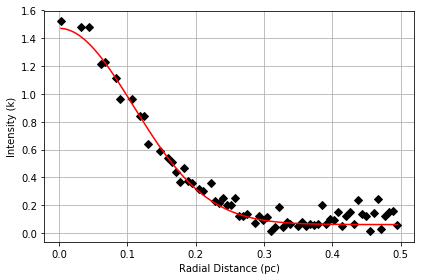

In [17]:
fils_umask.find_widths(try_nonparam=False, auto_cut=False, use_longest_path=False,max_dist=0.5 * u.pc,
                       verbose=True, add_width_to_length=False, xunit=u.pc, deconvolve_width=False)

In [18]:
print('raw:\t{0}'.format(fils_raw.lengths(unit=u.pc)))
print('umask:\t{0}'.format(fils_umask.lengths(unit=u.pc)))

raw:	[ 7.37088688] pc
umask:	[ 7.37088688] pc


In [19]:
print('raw:\t{0}'.format(fils_raw.widths(unit=u.pc)))
print('umask:\t{0}'.format(fils_umask.widths(unit=u.pc)))

raw:	(<Quantity [ 0.20437863] pc>, <Quantity [ 0.00385576] pc>)
umask:	(<Quantity [ 0.25528781] pc>, <Quantity [ 0.00495671] pc>)
